## **Basic Features**

**Purpose:** Engineer basic microstructure features from cleaned data

**What it does:**
- Loads cleaned data from `data/interim/`
- Computes fundamental LOB features
- Creates simple derived variables
- Saves engineered features to `data/processed/`

**Output:**
- Feature dataset in `data/processed/`
- Feature visualizations
- Correlation analysis
- Feature statistics


## Basic Features
*Foundational measures that are straightforward to compute and interpret*
1. 🟢 **Spread** - Simple price difference
2. 🟢 **Mid Price** - Average of best bid/ask
3. 🟢 **Relative Spread** - Normalized spread
4. 🟢 **Returns (Multiple Lags)** - Log price changes
5. 🟢 **Queue Depth (Top 1, Top 5, Cumulative)** - Raw quantities at levels
6. 🟢 **Spread at Multiple Levels** - Price differences at each level
7. 🟢 **Average Spread (Top N Levels)** - Mean of spreads
8. 🟢 **Intraday Patterns (Hour, Minute)** - Time-of-day indicators

## Intermediate Features
*Require some statistical/financial understanding but still conceptually accessible*

9. 🟢 **Weighted Mid Price (Microprice)** - Volume-weighted midpoint/fair value
10. **Rolling Volatility** - Standard deviation of returns
11. **VWAP** - Volume-weighted average price
12. 🟢 **Effective Spread** - VWAP difference
13. 🟢 **Depth Imbalance** - Normalized bid/ask difference
14. 🟢 **Basic Depth** - Total volume on bid and ask sides separately
15. 🟢 **Total Depth** - Sum of all bid and ask volumes
16. 🟢 **Depth Ratio** - Ratio of bid depth to ask depth
17. 🟢 **Average Volume Per Level** - Mean quantity across levels
18. **Queue Imbalance (Multiple Levels)** - Depth imbalance at specific levels
19. **Cumulative Volume Imbalance** - Absolute quantity difference
20. **Order Book Thickness** - Average quantity per level
21. **Depth Concentration** - Fraction of liquidity at top
22. **Time Since Event** - Temporal gap measurement

In [1]:
# ============================================================================
# 10_basic_features.ipynb
# Engineer basic microstructure features from cleaned LOB data
# ============================================================================

# %% Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# %% Project imports (assuming you ran `pip install -e .`)
from src.config import (
    INTERIM_DATA_DIR, 
    PROCESSED_DATA_DIR,
    FIGURES_DIR
)
from src.data.lob_loader import LOBLoader
# from src.features.basic_features import (
#     compute_mid_price,
#     compute_spread,
#     compute_imbalance,
#     compute_depth,
#     compute_weighted_mid,
#     compute_all_basic_features  # Convenience function
# )
# from src.utils.plotting import (
#     plot_price_series,
#     plot_feature_distributions,
#     plot_correlation_matrix
# )
# from src.utils.metrics import compute_summary_stats




In [1]:
# ============================================================================
# 10_basic_features.ipynb
# Purpose: Engineer basic microstructure features from cleaned data
# ============================================================================

# %% Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from pathlib import Path


# Visualization settings
plt.style.use('seaborn-v0_8-paper')  
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',        
    'axes.labelweight': 'bold',    
    'axes.titleweight': 'bold',   
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
%matplotlib inline


from src.config import RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR


In [2]:
# Configuration
SYMBOL = "BTCUSDT"
INPUT_FILE = INTERIM_DATA_DIR / f"{SYMBOL}_lob_cleaned.parquet"
OUTPUT_FILE = PROCESSED_DATA_DIR / f"{SYMBOL}_basic_parquet.csv"

# Create output directories if needed
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Input: {INPUT_FILE}")
print(f"Output: {OUTPUT_FILE}")

Input: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/BTCUSDT_lob_cleaned.parquet
Output: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/BTCUSDT_basic_parquet.csv


In [3]:
# Load cleaned data
print("Loading cleaned LOB data...")
lob_df = pd.read_parquet(INPUT_FILE)

print(f"Loaded {len(lob_df):,} snapshots")
print(f"Date range: {lob_df['timestamp'].min()} to {lob_df['timestamp'].max()}")
print(f"\nColumns: {lob_df.columns.tolist()}")
lob_df.head()

Loading cleaned LOB data...
Loaded 3,154 snapshots
Date range: 2025-10-09 17:07:08+00:00 to 2025-10-09 18:07:07+00:00

Columns: ['timestamp', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'bid_price_4', 'bid_volume_4', 'bid_price_5', 'bid_volume_5', 'bid_price_6', 'bid_volume_6', 'bid_price_7', 'bid_volume_7', 'bid_price_8', 'bid_volume_8', 'bid_price_9', 'bid_volume_9', 'bid_price_10', 'bid_volume_10', 'bid_price_11', 'bid_volume_11', 'bid_price_12', 'bid_volume_12', 'bid_price_13', 'bid_volume_13', 'bid_price_14', 'bid_volume_14', 'bid_price_15', 'bid_volume_15', 'bid_price_16', 'bid_volume_16', 'bid_price_17', 'bid_volume_17', 'bid_price_18', 'bid_volume_18', 'bid_price_19', 'bid_volume_19', 'bid_price_20', 'bid_volume_20', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'ask_price_4', 'ask_volume_4', 'ask_price_5', 'ask_volume_5', 'ask_price_6', 'ask_volume_6', 'ask_price_7', 'ask_volume_7',

,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,bid_price_4,bid_volume_4,bid_price_5,...,ask_price_16,ask_volume_16,ask_price_17,ask_volume_17,ask_price_18,ask_volume_18,ask_price_19,ask_volume_19,ask_price_20,ask_volume_20
0,2025-10-09 17:07:08+00:00,119900.47,0.00094,119900.45,0.00229,119890.00,0.00834,119885.26,0.04879,119788.84,...,120595.00,0.24645,120605.85,0.00160,120625.00,0.29963,120632.50,0.00006,120663.16,0.00099
1,2025-10-09 17:07:09+00:00,119900.47,0.00094,119900.45,0.00229,119890.00,0.00834,119885.26,0.04879,119788.82,...,120526.76,0.00010,120536.00,0.12204,120595.00,0.24645,120605.85,0.00160,120625.00,0.29963
2,2025-10-09 17:07:10+00:00,119900.47,0.00094,119900.45,0.00229,119890.00,0.00834,119885.26,0.04879,119788.82,...,120526.76,0.00010,120536.00,0.12204,120595.00,0.24645,120605.85,0.00160,120625.00,0.29963
3,2025-10-09 17:07:11+00:00,119900.47,0.00094,119900.45,0.00229,119890.00,0.00834,119885.27,1.35252,119885.26,...,120526.76,0.00010,120536.00,0.12204,120595.00,0.24645,120605.85,0.00160,120625.00,0.29963
4,2025-10-09 17:07:12+00:00,119900.48,0.04878,119900.47,0.00094,119900.45,0.00229,119890.01,1.35252,119890.00,...,120605.85,0.00160,120632.50,0.00006,120663.16,0.00099,120672.83,0.01021,120735.87,0.00004


In [17]:
# Compute basic features using imported functions

print("\n=== Computing Basic Features ===\n")

# create basic_featured dataframe with timestamps 
basic_features = pd.DataFrame(index=lob_df.index)
basic_features['timestamp'] = lob_df['timestamp']

###################################################
# mid price features
###################################################

from src.features.basic_features import (
    compute_mid_price,
    compute_weighted_mid
)

print("Computing mid-price....")
basic_features['mid_price'] = compute_mid_price(
    bid_price=lob_df['bid_price_1'],
    ask_price=lob_df['ask_price_1']
)

print("Computing weighted mid-price (micro price)....")
basic_features['weighted_mid'] = compute_weighted_mid(
    bid_price=lob_df['bid_price_1'],
    ask_price=lob_df['ask_price_1'],
    bid_volume=lob_df['bid_volume_1'],
    ask_volume=lob_df['ask_volume_1']
)


print(f"\nAdded mid price features. Total columns: {len(basic_features.columns)}\n")


###################################################
# spread features
###################################################

from src.features.basic_features import (
    compute_spread,
    compute_average_spread,
    compute_spreads_all_levels
)

print("Computing spread....")
spread_features = compute_spread(
    bid_price=lob_df['bid_price_1'],
    ask_price=lob_df['ask_price_1'],
    mid_price=basic_features['mid_price']
)
basic_features['spread_abs'] = spread_features['spread_abs']
basic_features['spread_bps'] = spread_features['spread_bps']


print("Computing average spread....")
num_levels = 10
basic_features['average_spread'] = compute_average_spread(
    bid_prices=lob_df[[f'bid_price_{i}' for i in range(1, num_levels+1)]],
    ask_prices=lob_df[[f'ask_price_{i}' for i in range(1, num_levels+1)]],
    n_levels=num_levels
)

print("Computing all spreads at once....")
spread_features = compute_spreads_all_levels(
    bid_prices=lob_df,
    ask_prices=lob_df,
    n_levels=10
)

# Add all spread features to main dataframe
basic_features = pd.concat([basic_features, spread_features], axis=1)

print(f"\nAdded spread features. Total columns: {len(basic_features.columns)}\n")


###################################################
# returns features
###################################################

from src.features.basic_features import (
    compute_log_returns_multiple_lags
)

print("Compute multiple lags at once....")
return_lags = [1, 2, 3, 5, 10, 20, 30, 60]
return_features = compute_log_returns_multiple_lags(
    prices=basic_features['mid_price'],
    lags=return_lags
)

basic_features = pd.concat([basic_features, return_features], axis=1)

print(f"\nAdded returns features. Total columns: {len(basic_features.columns)}\n")

###################################################
# flow imbalance features
###################################################

from src.features.basic_features import (
    compute_imbalance,
    compute_multi_level_imbalance,
    compute_volume_weighted_imbalance
)

print("Computing Top-of-book imbalance....")
basic_features['imbalance_top'] = compute_imbalance(
    lob_df['bid_volume_1'],
    lob_df['ask_volume_1']
)

print("Computing 5-level imbalance....")
basic_features['imbalance_5level'] = compute_multi_level_imbalance(lob_df, levels=5)

print("Computing 10-level imbalance....")
basic_features['imbalance_10level'] = compute_multi_level_imbalance(lob_df, levels=10)

print("Weighted imbalance (exponential decay)....")
basic_features['imbalance_weighted'] = compute_volume_weighted_imbalance(
    lob_df, 
    levels=5, 
    decay_factor=0.8
)

print("Computing Alternative: log-ratio imbalance (for some models this works better)....")
basic_features['imbalance_log'] = compute_imbalance(
    lob_df['bid_volume_1'],
    lob_df['ask_volume_1'],
    method='log_ratio'
)
print(f"\nAdded imbalance features. Total columns: {len(lob_df.columns)}\n")


####################################################################
# Depth Imbalance features (Liquidity Imbalance at Multiple Depths)
#####################################################################

from src.features.basic_features import (
    compute_depth,
    compute_total_depth,
    compute_depth_imbalance,
    compute_depth_ratio,
    compute_avg_volume_per_level
)

print("Computing Basic depth....")
depth_features = compute_depth(lob_df, levels=[1, 5, 10]) # Top 1, top 5, top 10 levels
basic_features = pd.concat([basic_features, depth_features], axis=1)

print("Computing Total depth....")
total_depth = compute_total_depth(lob_df, levels=[5, 10])
basic_features = pd.concat([basic_features, total_depth], axis=1)

print("Computing Depth imbalance....")
depth_imb = compute_depth_imbalance(lob_df, levels=[5, 10])
basic_features = pd.concat([basic_features, depth_imb], axis=1)

print("Computing Depth ratio....")
depth_ratio = compute_depth_ratio(basic_features, levels=[5, 10])
basic_features = pd.concat([basic_features, depth_ratio], axis=1)

print("Computing Average volume per level....")
avg_vol = compute_avg_volume_per_level(lob_df, levels=[5, 10])
basic_features = pd.concat([basic_features, avg_vol], axis=1)

print(f"\nAdded depth features. Total columns: {len(basic_features.columns)}\n")

####################################################################
# Queue Depth Features 
#####################################################################

from src.features.basic_features import (
    compute_queue_depth_top_n,
    compute_cumulative_queue_depth
)


print("Computing Top 5 levels on both sides ...")
top5_depth = compute_queue_depth_top_n(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    n=5
)
basic_features = pd.concat([basic_features, top5_depth], axis=1)

print("Cumulative depth (total liquidity measure) ...")
cumulative_depth = compute_cumulative_queue_depth(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    n_levels=10
)

basic_features = pd.concat([basic_features, cumulative_depth], axis=1)


print(f"\nAdded queue depth features. Total columns: {len(basic_features.columns)}\n")


####################################################################
# Time Features 
#####################################################################

from src.features.basic_features import (
    compute_intraday_time_features,
    compute_trading_session_features,
)
# Ensure timestamps are datetime objects
if 'timestamp' not in basic_features.columns:
    raise ValueError("Need 'timestamp' column in dataframe")

basic_features['timestamp'] = pd.to_datetime(basic_features['timestamp'])

print("Computing basic intraday time features....")
time_features = compute_intraday_time_features(
    timestamps=lob_df['timestamp'],
    include_cyclical=True
)
basic_features = pd.concat([basic_features, time_features], axis=1)

print("Computing trading session features....")
session_features = compute_trading_session_features(
    timestamps=lob_df['timestamp'],
    market_open='09:30:00',
    market_close='16:00:00'
)
basic_features = pd.concat([basic_features, session_features], axis=1)


print(f"\nAdded time features. Total columns: {len(basic_features.columns)}\n")

####################################################################
# End of Features 
#####################################################################

#  Use convenience function (recommended for production)
# lob_df = compute_all_basic_features(lob_df)

print("\n=== Feature engineering complete! ===\n")





=== Computing Basic Features ===

Computing mid-price....
Computing weighted mid-price (micro price)....

Added mid price features. Total columns: 3

Computing spread....
Computing average spread....
Computing all spreads at once....

Added spread features. Total columns: 16

Compute multiple lags at once....

Added returns features. Total columns: 24

Computing Top-of-book imbalance....
Computing 5-level imbalance....
Computing 10-level imbalance....
Weighted imbalance (exponential decay)....
Computing Alternative: log-ratio imbalance (for some models this works better)....

Added imbalance features. Total columns: 81

Computing Basic depth....
Computing Total depth....
Computing Depth imbalance....
Computing Depth ratio....
Computing Average volume per level....

Added depth features. Total columns: 41

Computing Top 5 levels on both sides ...
Cumulative depth (total liquidity measure) ...

Added queue depth features. Total columns: 54

Computing basic intraday time features....
Com

In [18]:

from src.features.basic_features import (
    compute_summary_stats, 
    print_feature_summary,
    get_feature_columns
)

# Create output directory
os.makedirs('reports/tables', exist_ok=True)

# Analyze ALL engineered features (recommended)
print("\n=== COMPLETE FEATURE ANALYSIS ===")
summary_stats = print_feature_summary(
    basic_features,
    exclude_raw_lob=True,  # Excludes bid_price_*, ask_price_*, etc.
    save_path='reports/tables/all_features_summary.csv'
)




=== COMPLETE FEATURE ANALYSIS ===

📊 Analyzing 59 features...

FEATURE SUMMARY STATISTICS

Dataset: 3,154 observations
Features: 59 columns

--------------------------------------------------------------------------------
DATA QUALITY OVERVIEW
--------------------------------------------------------------------------------
                    count  missing  missing_pct  n_zeros  n_infinite  n_outliers  outlier_pct
mid_price          3154.0      0.0     0.000000      0.0         0.0         0.0     0.000000
weighted_mid       3154.0      0.0     0.000000      0.0         0.0        42.0     1.331642
spread_abs         3154.0      0.0     0.000000      0.0         0.0       541.0    17.152822
spread_bps         3154.0      0.0     0.000000      0.0         0.0       467.0    14.806595
average_spread     3154.0      0.0     0.000000      0.0         0.0         0.0     0.000000
spread_level_1     3154.0      0.0     0.000000      0.0         0.0       541.0    17.152822
spread_level_2  

In [26]:
basic_features.head()

,timestamp,mid_price,weighted_mid,spread_abs,spread_bps,average_spread,spread_level_1,spread_level_2,spread_level_3,spread_level_4,...,seconds_since_midnight,hour_sin,hour_cos,minute_sin,minute_cos,minutes_since_open,minutes_until_close,session_progress,is_market_hours,session_period
0,2025-10-09 17:07:08+00:00,119949.705,119900.712652,98.47,8.209274,382.252,98.47,98.50,109.00,381.88,...,61628,-0.965926,-0.258819,0.669131,0.743145,457.133333,-67.133333,1.172137,False,post_close
1,2025-10-09 17:07:09+00:00,119949.705,119900.712652,98.47,8.209274,380.758,98.47,98.50,109.00,381.86,...,61629,-0.965926,-0.258819,0.669131,0.743145,457.150000,-67.150000,1.172179,False,post_close
2,2025-10-09 17:07:10+00:00,119949.705,119900.712652,98.47,8.209274,380.758,98.47,98.50,109.00,381.86,...,61630,-0.965926,-0.258819,0.669131,0.743145,457.166667,-67.166667,1.172222,False,post_close
3,2025-10-09 17:07:11+00:00,119949.705,119900.712652,98.47,8.209274,366.823,98.47,98.50,109.00,381.85,...,61631,-0.965926,-0.258819,0.669131,0.743145,457.183333,-67.183333,1.172265,False,post_close
4,2025-10-09 17:07:12+00:00,119949.710,119911.668973,98.46,8.208440,366.928,98.46,98.48,98.55,377.11,...,61632,-0.965926,-0.258819,0.669131,0.743145,457.200000,-67.200000,1.172308,False,post_close


In [27]:
# Analyze specific feature groups
feature_groups = get_feature_columns(basic_features)

print("\n=== SPREAD FEATURES ===")
spread_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['spread'],
    save_path='reports/tables/spread_features_summary.csv'
)

print("\n=== IMBALANCE FEATURES ===")
imbalance_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['imbalance'],
    save_path='reports/tables/imbalance_features_summary.csv'
)

print("\n=== DEPTH FEATURES ===")
depth_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['depth'],
    save_path='reports/tables/depth_features_summary.csv'
)

print("\n=== RETURN FEATURES ===")
return_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['returns'],
    save_path='reports/tables/return_features_summary.csv'
)




=== SPREAD FEATURES ===

📊 Analyzing 13 features...

FEATURE SUMMARY STATISTICS

Dataset: 3,154 observations
Features: 13 columns

--------------------------------------------------------------------------------
DATA QUALITY OVERVIEW
--------------------------------------------------------------------------------
                  count  missing  missing_pct  n_zeros  n_infinite  n_outliers  outlier_pct
spread_abs       3154.0      0.0          0.0      0.0         0.0       541.0    17.152822
spread_bps       3154.0      0.0          0.0      0.0         0.0       467.0    14.806595
average_spread   3154.0      0.0          0.0      0.0         0.0         0.0     0.000000
spread_level_1   3154.0      0.0          0.0      0.0         0.0       541.0    17.152822
spread_level_2   3154.0      0.0          0.0      0.0         0.0       534.0    16.930881
spread_level_3   3154.0      0.0          0.0      0.0         0.0       475.0    15.060241
spread_level_4   3154.0      0.0        

In [28]:
# Quick exploration - see what features we have
print("\n=== FEATURE GROUPS ===")
for group_name, cols in feature_groups.items():
    if group_name not in ['raw_lob', 'metadata', 'all_engineered']:
        print(f"\n{group_name.upper()}: {len(cols)} features")
        print(f"  {cols}")



=== FEATURE GROUPS ===

PRICE: 2 features
  ['mid_price', 'weighted_mid']

SPREAD: 13 features
  ['spread_abs', 'spread_bps', 'average_spread', 'spread_level_1', 'spread_level_2', 'spread_level_3', 'spread_level_4', 'spread_level_5', 'spread_level_6', 'spread_level_7', 'spread_level_8', 'spread_level_9', 'spread_level_10']

RETURNS: 8 features
  ['log_return_lag_1', 'log_return_lag_2', 'log_return_lag_3', 'log_return_lag_5', 'log_return_lag_10', 'log_return_lag_20', 'log_return_lag_30', 'log_return_lag_60']

IMBALANCE: 7 features
  ['imbalance_top', 'imbalance_5level', 'imbalance_10level', 'imbalance_weighted', 'imbalance_log', 'depth_imbalance_5', 'depth_imbalance_10']

DEPTH: 21 features
  ['bid_depth_5', 'ask_depth_5', 'bid_depth_10', 'ask_depth_10', 'total_depth_5', 'total_depth_10', 'depth_imbalance_5', 'depth_imbalance_10', 'queue_depth_bid_1', 'queue_depth_bid_2', 'queue_depth_bid_3', 'queue_depth_bid_4', 'queue_depth_bid_5', 'queue_depth_ask_1', 'queue_depth_ask_2', 'queue_dep

In [29]:
# Top insights
print("\n=== TOP INSIGHTS ===")
print("\n🔝 Most skewed features:")
print(summary_stats.nlargest(5, 'skewness', keep='all')[['mean', 'std', 'skewness']])

print("\n🔝 Heaviest tails:")
print(summary_stats.nlargest(5, 'kurtosis')[['mean', 'std', 'kurtosis']])

print("\n🔝 Highest variation (CV):")
print(summary_stats.nlargest(5, 'cv')[['mean', 'std', 'cv']])

print("\n🔝 Most outliers:")
print(summary_stats.nlargest(5, 'outlier_pct')[['mean', 'std', 'n_outliers', 'outlier_pct']])


=== TOP INSIGHTS ===

🔝 Most skewed features:
                       mean       std   skewness
log_return_lag_1   0.000002  0.000036  23.656687
log_return_lag_2   0.000005  0.000052  16.257607
log_return_lag_3   0.000007  0.000065  13.247673
log_return_lag_5   0.000011  0.000087  10.119672
log_return_lag_10  0.000023  0.000128   7.040216

🔝 Heaviest tails:
                       mean       std    kurtosis
log_return_lag_1   0.000002  0.000036  660.222924
log_return_lag_2   0.000005  0.000052  305.504168
log_return_lag_3   0.000007  0.000065  197.444886
log_return_lag_5   0.000011  0.000087  111.607849
queue_depth_bid_5  0.050082  0.070957   72.718274

🔝 Highest variation (CV):
                      mean       std           cv
minute_cos        0.000686  0.708561  1032.157196
minute_sin        0.005827  0.705850   121.124950
log_return_lag_1  0.000002  0.000036    15.561854
log_return_lag_2  0.000005  0.000052    11.315215
log_return_lag_3  0.000007  0.000065     9.504827

🔝 Most outli

In [41]:

from src.utils.plotting import (
    create_comprehensive_feature_report,
    plot_feature_distributions,
    plot_feature_group_comparison,
    plot_time_series_features,
    plot_feature_relationships,
    plot_correlation_heatmap
)
# First compute summary stats if you haven't already
summary_stats = print_feature_summary(basic_features, exclude_raw_lob=True)

# Create output directory
os.makedirs('reports/figures', exist_ok=True)

# # Create ALL visualizations at once (comprehensive report)
# create_comprehensive_feature_report(
#     df=basic_features,
#     summary_stats=summary_stats,
#     output_dir='reports/figures'
# )




📊 Analyzing 59 features...

FEATURE SUMMARY STATISTICS

Dataset: 3,154 observations
Features: 59 columns

--------------------------------------------------------------------------------
DATA QUALITY OVERVIEW
--------------------------------------------------------------------------------
                    count  missing  missing_pct  n_zeros  n_infinite  n_outliers  outlier_pct
mid_price          3154.0      0.0     0.000000      0.0         0.0         0.0     0.000000
weighted_mid       3154.0      0.0     0.000000      0.0         0.0        42.0     1.331642
spread_abs         3154.0      0.0     0.000000      0.0         0.0       541.0    17.152822
spread_bps         3154.0      0.0     0.000000      0.0         0.0       467.0    14.806595
average_spread     3154.0      0.0     0.000000      0.0         0.0         0.0     0.000000
spread_level_1     3154.0      0.0     0.000000      0.0         0.0       541.0    17.152822
spread_level_2     3154.0      0.0     0.000000    


=== FEATURE DISTRIBUTIONS ===
💾 Saved to: reports/figures/spread_distributions.png


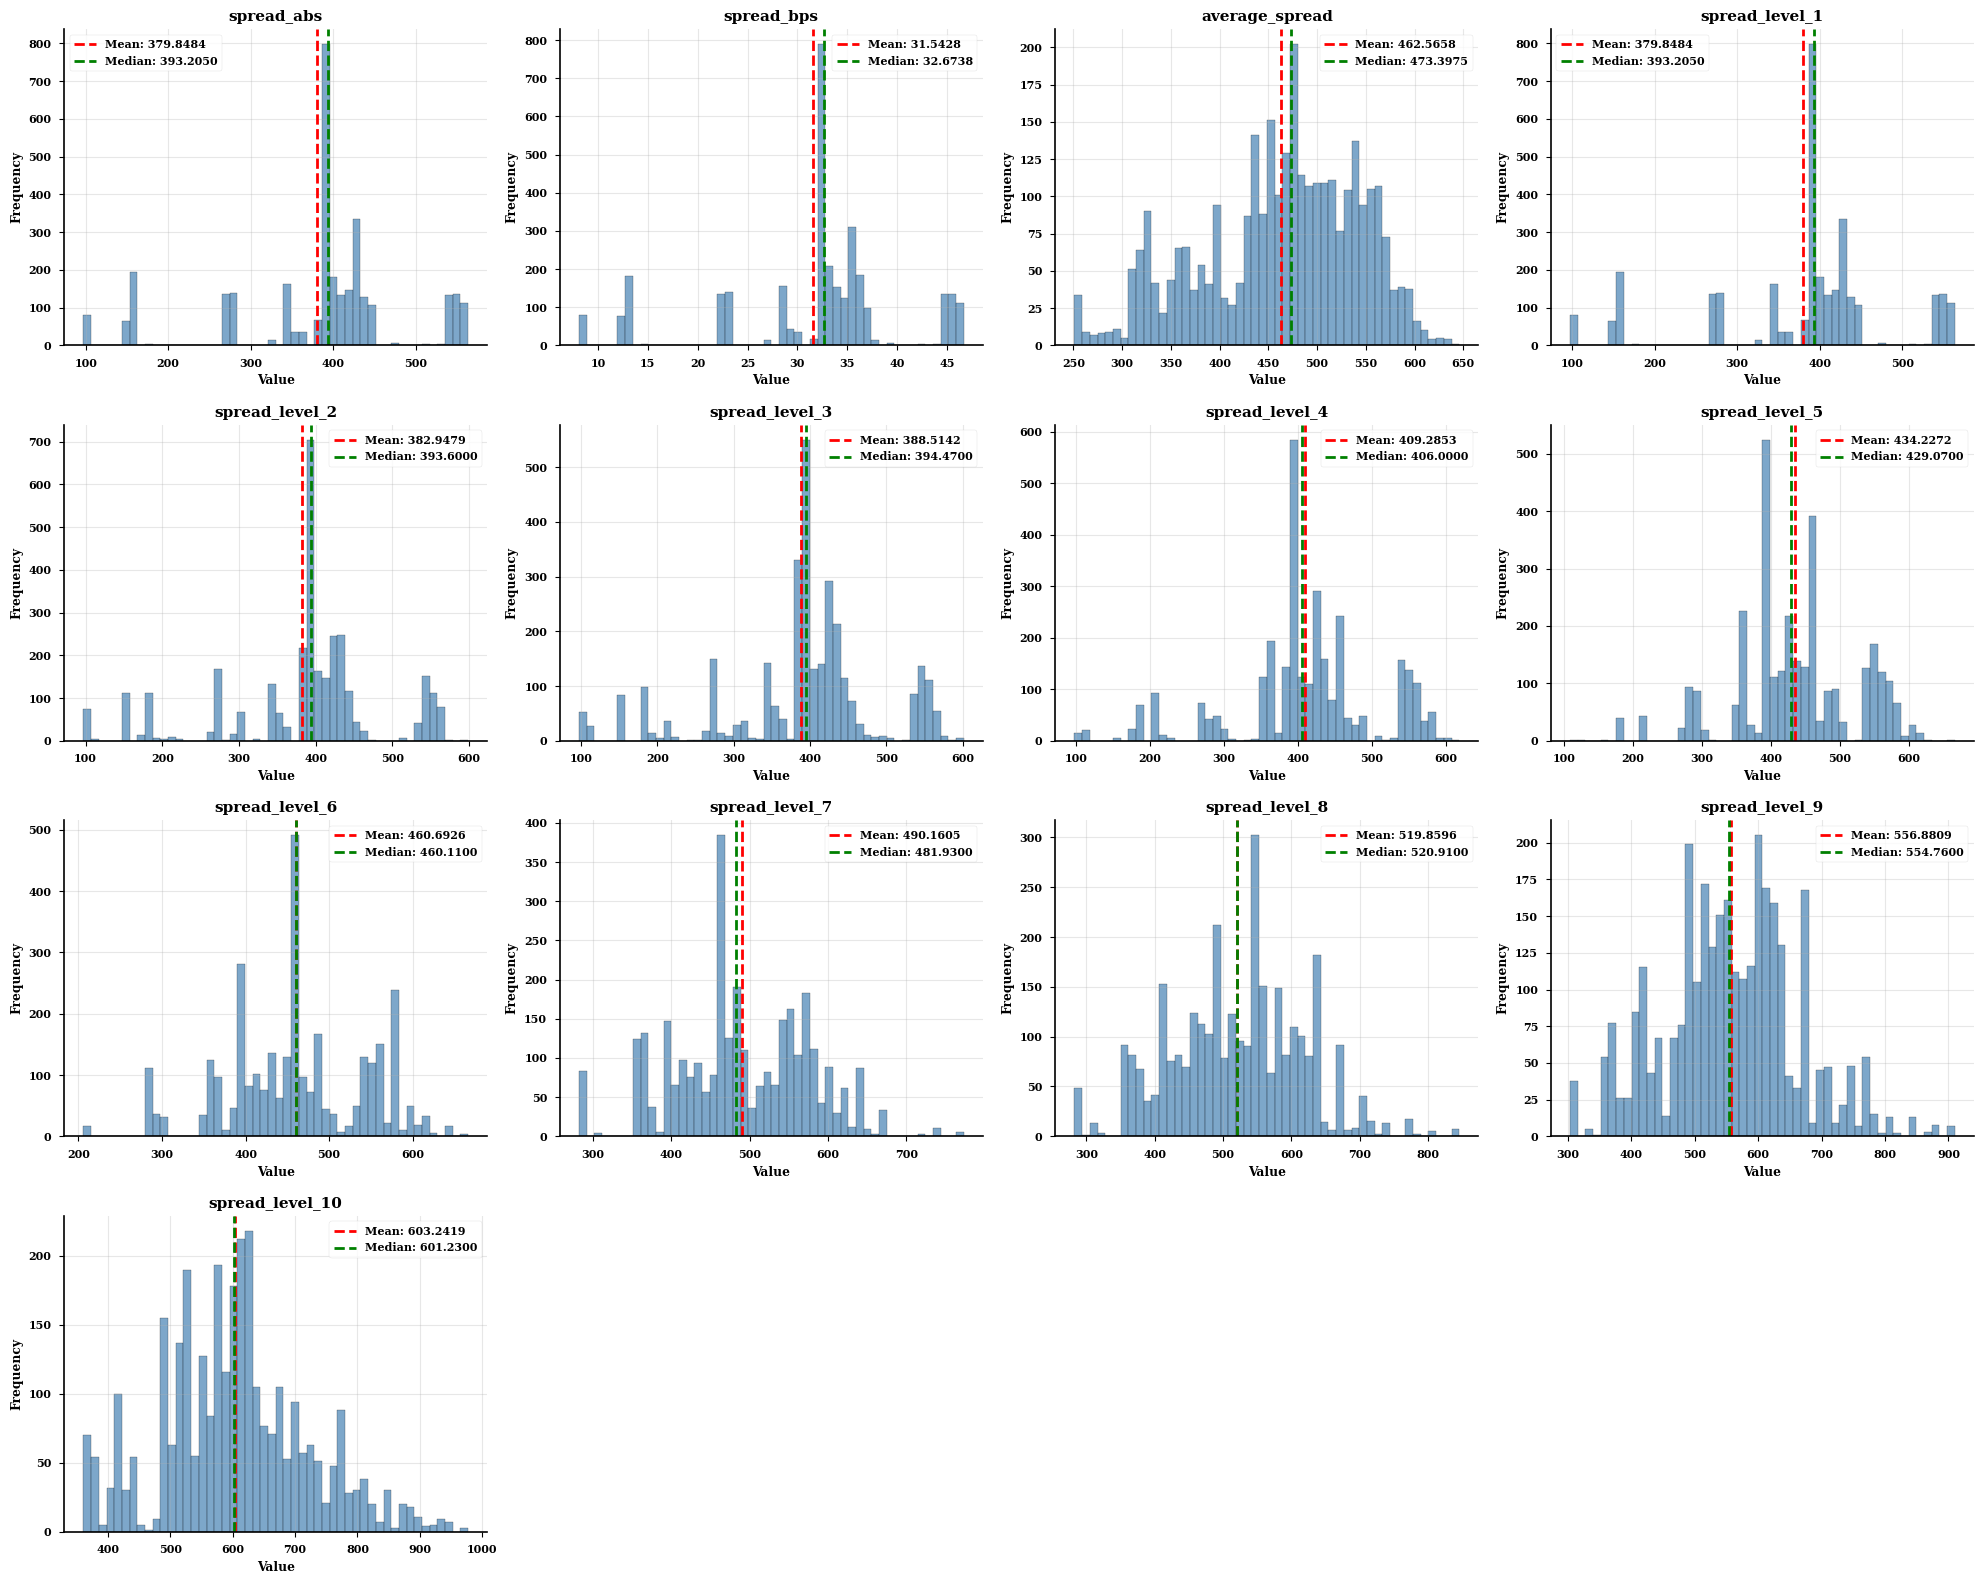

In [37]:
# Create individual visualizations

# Distribution plots
print("\n=== FEATURE DISTRIBUTIONS ===")
feature_groups = get_feature_columns(basic_features)
plot_feature_distributions(
    basic_features, 
    feature_cols=feature_groups['spread'],
    save_path='reports/figures/spread_distributions.png'
)




=== FEATURE GROUP COMPARISON ===
💾 Saved to: reports/figures/group_comparison.png


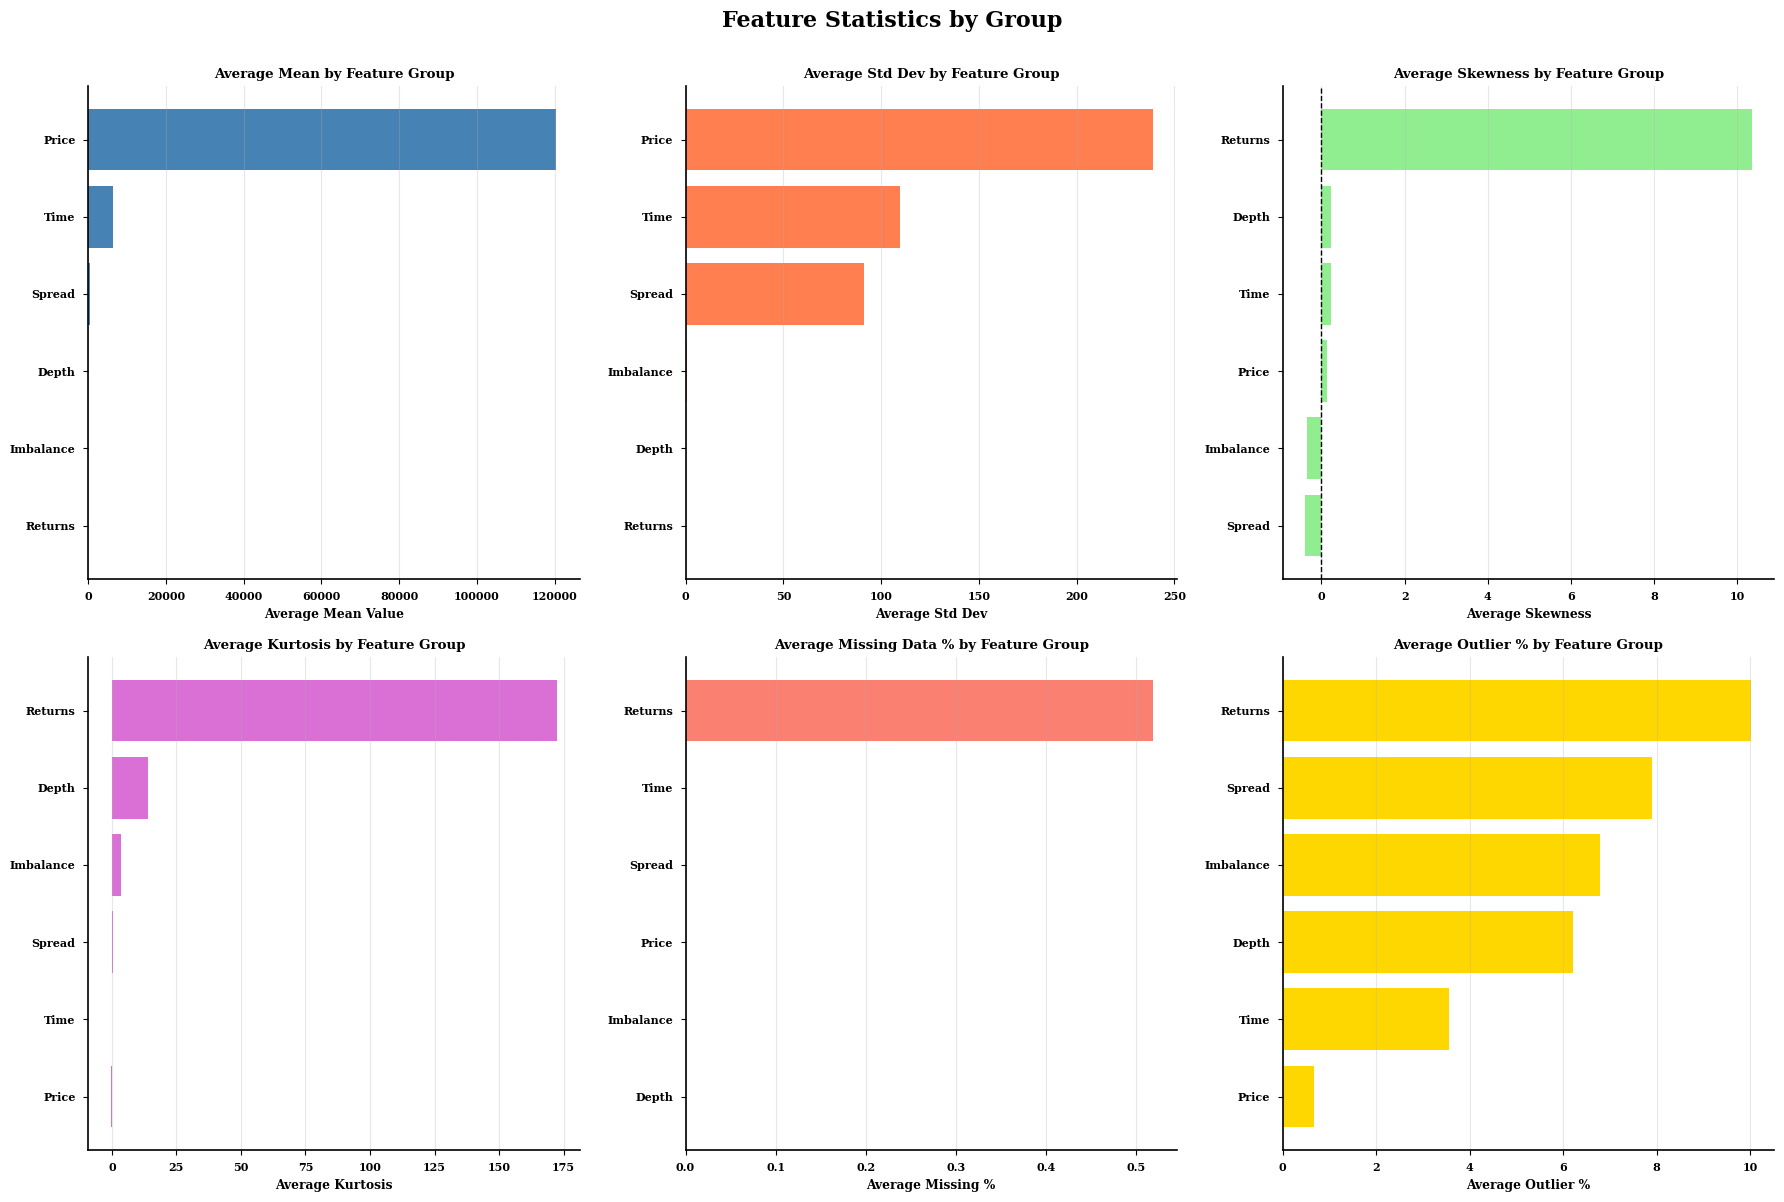

In [38]:
# Feature group comparison
print("\n=== FEATURE GROUP COMPARISON ===")
plot_feature_group_comparison(
    basic_features,
    summary_stats,
    save_path='reports/figures/group_comparison.png'
)




=== TIME SERIES ===
💾 Saved to: reports/figures/time_series.png


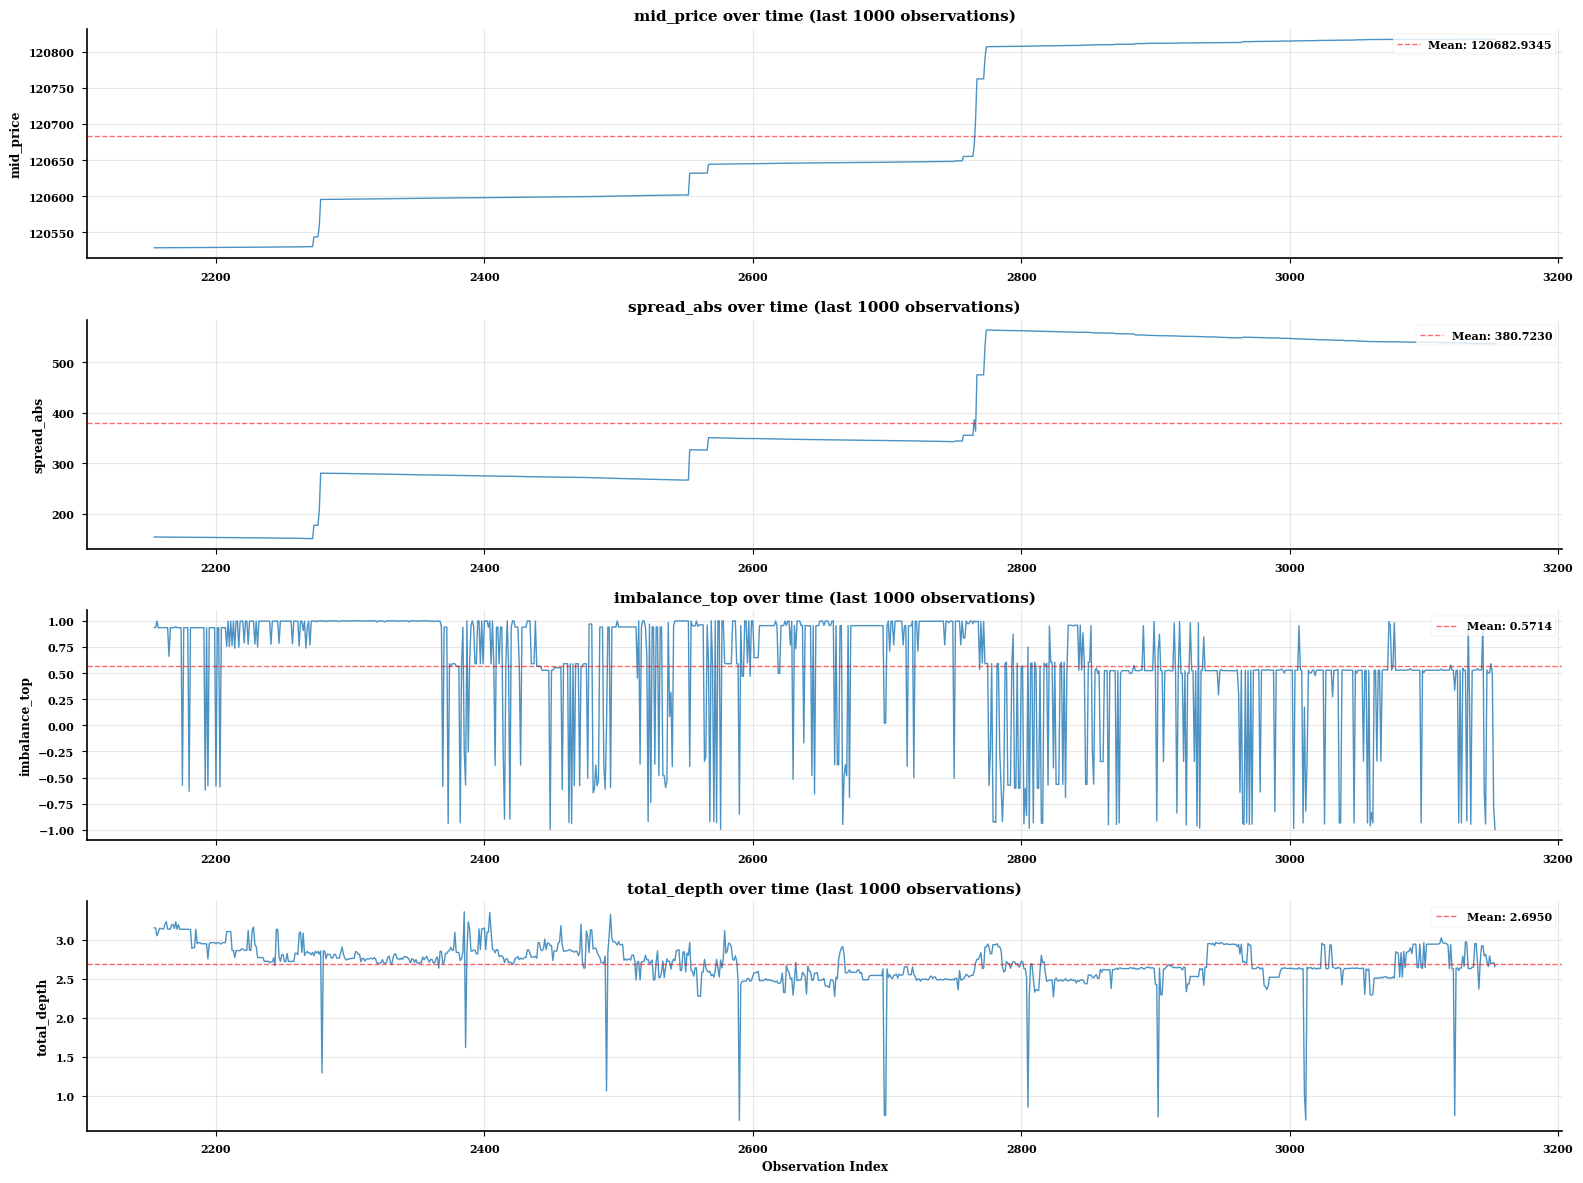

In [39]:
# Time series
print("\n=== TIME SERIES ===")
plot_time_series_features(
    basic_features,
    feature_cols=['mid_price', 'spread_abs', 'imbalance_top', 'total_depth'],
    n_samples=1000,
    save_path='reports/figures/time_series.png'
)




=== FEATURE RELATIONSHIPS ===
💾 Saved to: reports/figures/relationships.png


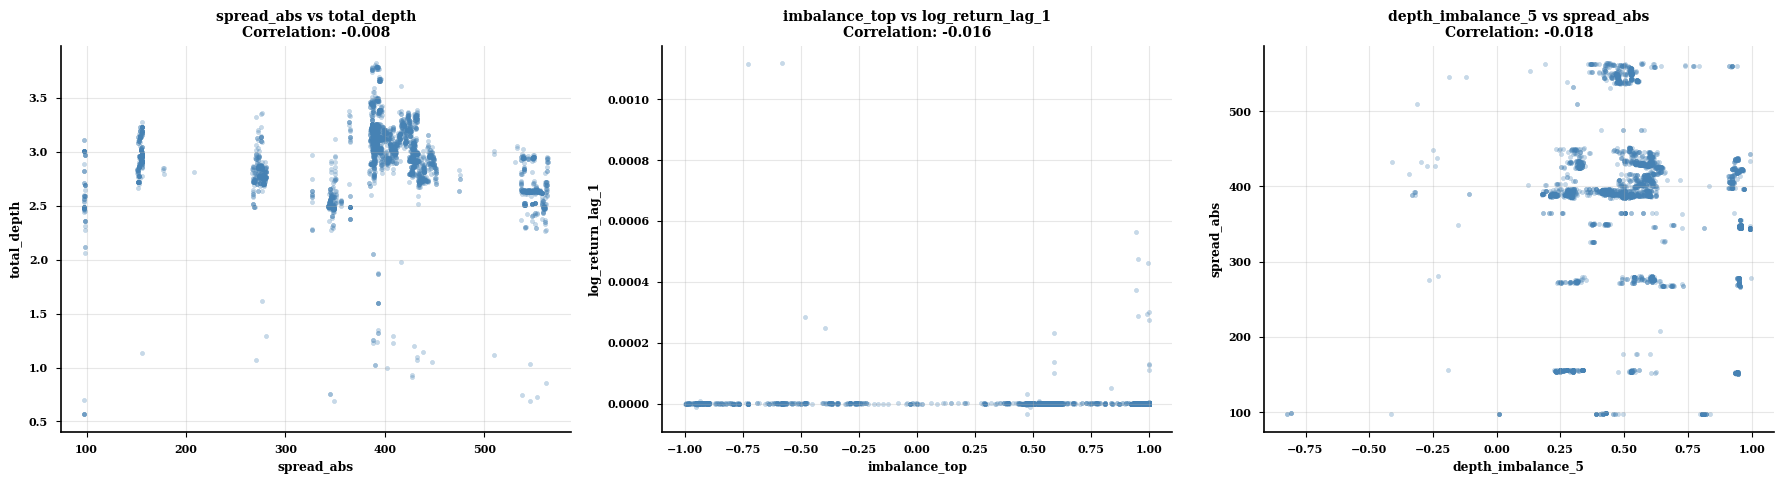

In [42]:
# Relationships
print("\n=== FEATURE RELATIONSHIPS ===")
plot_feature_relationships(
    basic_features,
    feature_pairs=[
        ('spread_abs', 'total_depth'),
        ('imbalance_top', 'log_return_lag_1'),
        ('depth_imbalance_5', 'spread_abs')
    ],
    save_path='reports/figures/relationships.png'
)


=== CORRELATION ANALYSIS ===
💾 Saved to: reports/figures/correlation_matrix.png


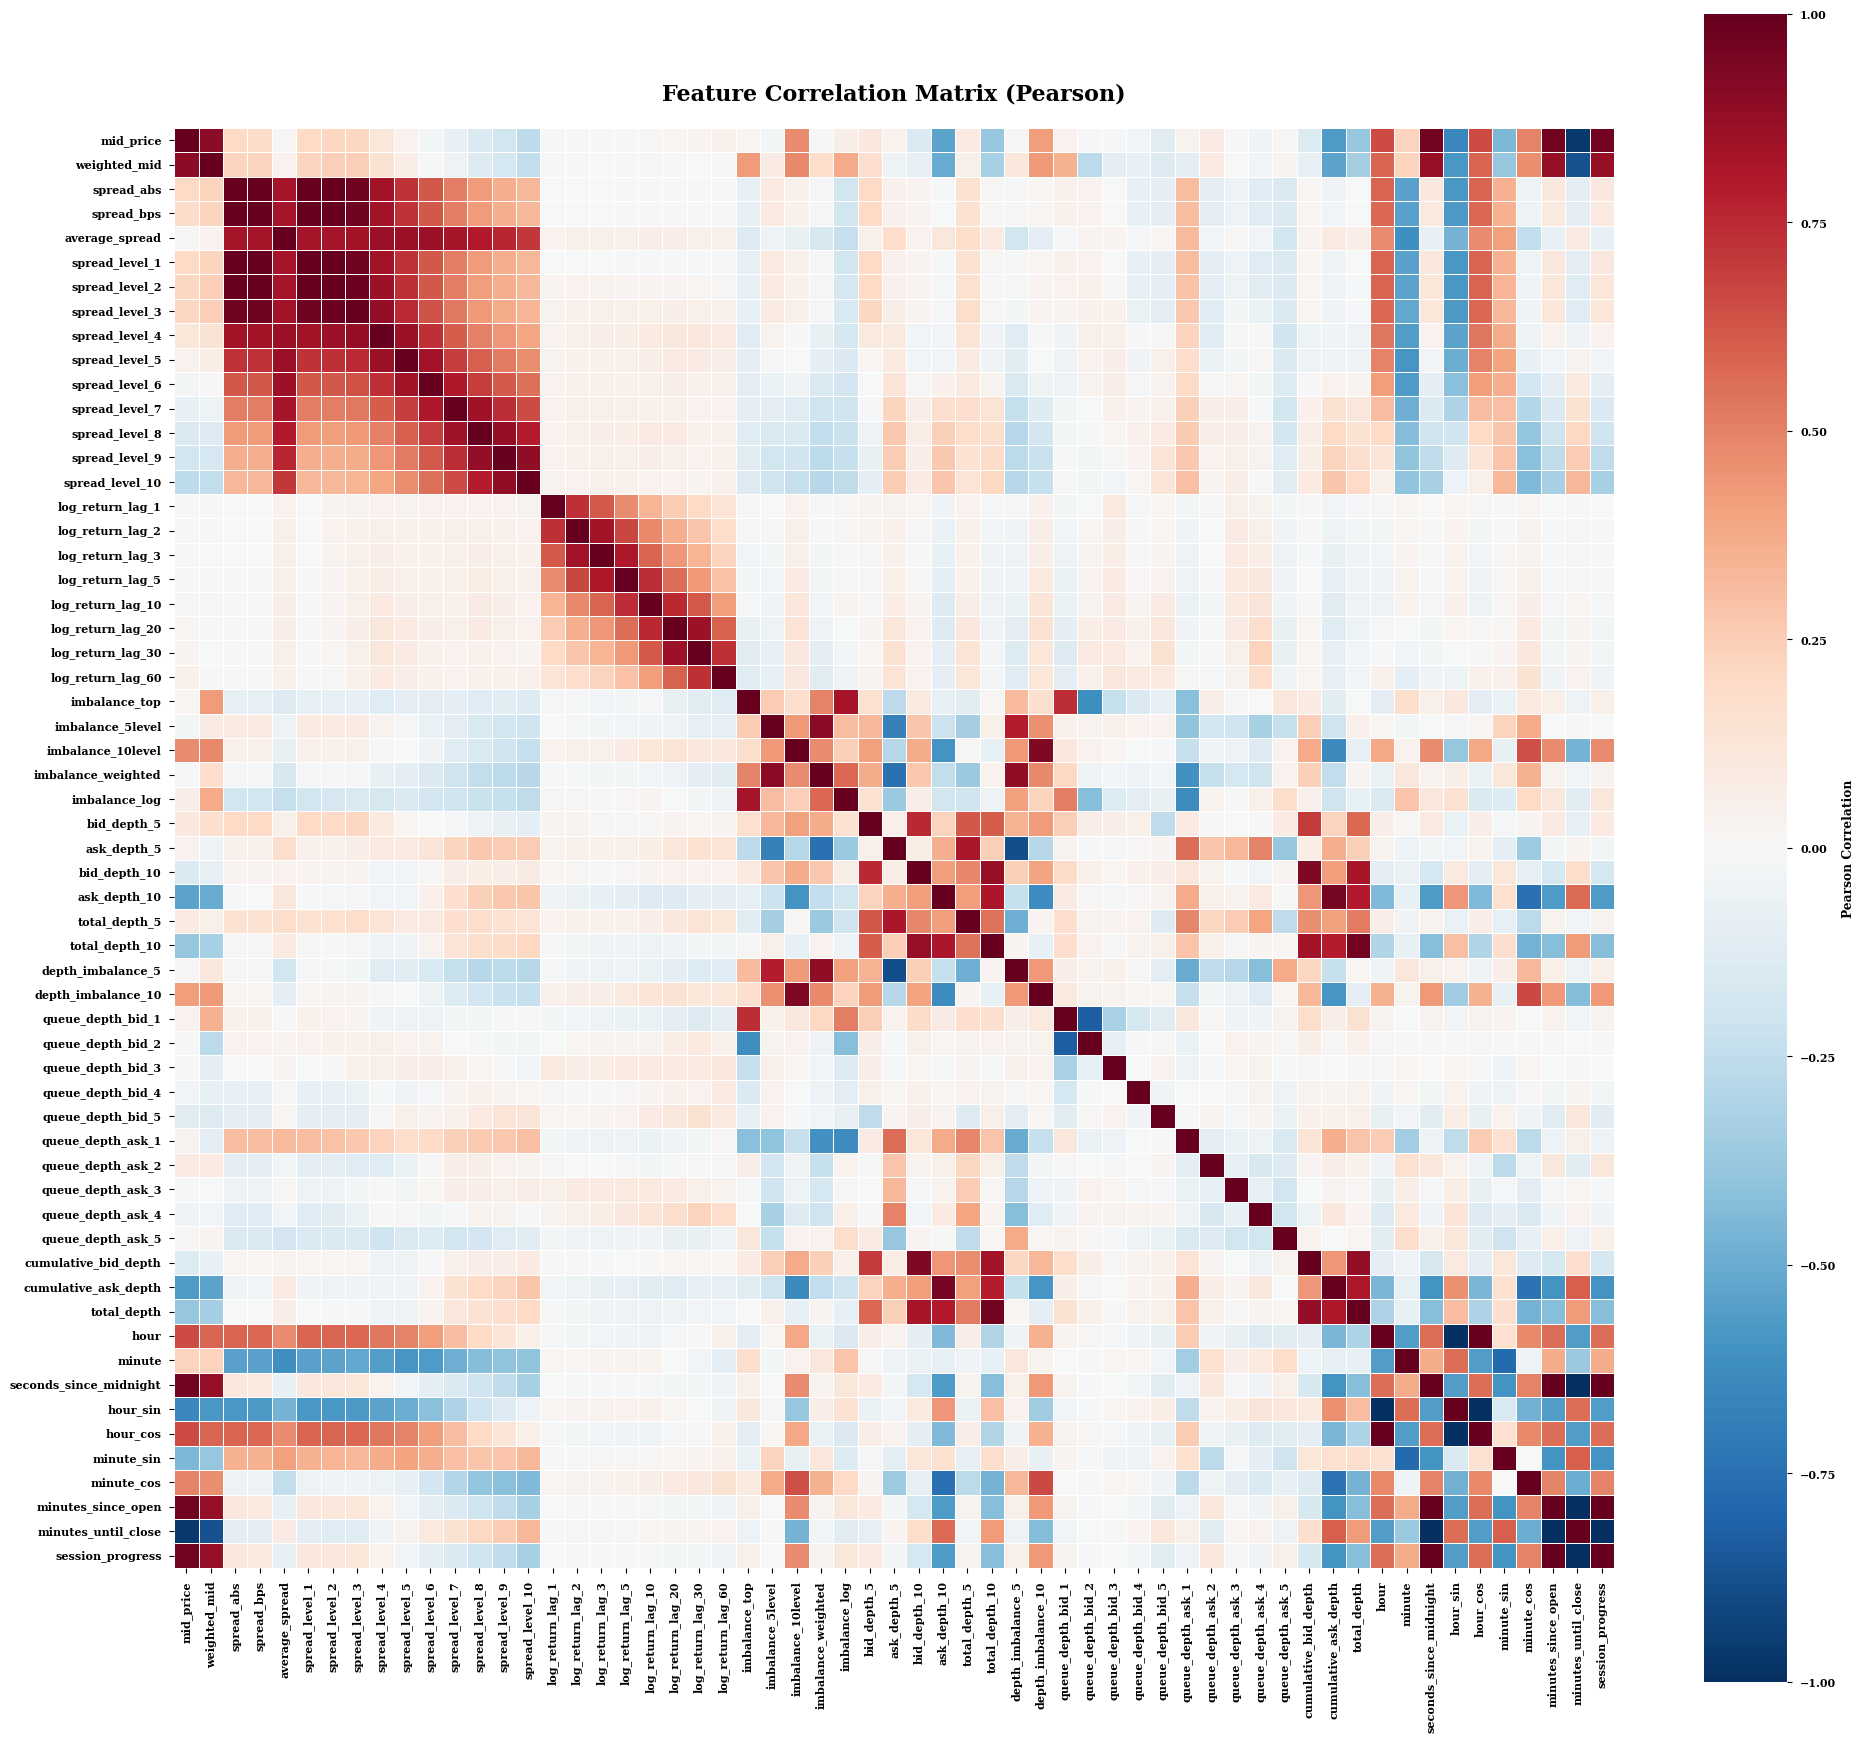

Highly correlated feature pairs (|r| > 0.7):
  mid_price <-> weighted_mid: 0.898
  mid_price <-> seconds_since_midnight: 0.965
  mid_price <-> minutes_since_open: 0.965
  mid_price <-> minutes_until_close: -0.965
  mid_price <-> session_progress: 0.965
  weighted_mid <-> seconds_since_midnight: 0.875
  weighted_mid <-> minutes_since_open: 0.875
  weighted_mid <-> minutes_until_close: -0.875
  weighted_mid <-> session_progress: 0.875
  spread_abs <-> spread_bps: 1.000
  spread_abs <-> average_spread: 0.831
  spread_abs <-> spread_level_1: 1.000
  spread_abs <-> spread_level_2: 0.995
  spread_abs <-> spread_level_3: 0.969
  spread_abs <-> spread_level_4: 0.841
  spread_abs <-> spread_level_5: 0.722
  spread_bps <-> average_spread: 0.831
  spread_bps <-> spread_level_1: 1.000
  spread_bps <-> spread_level_2: 0.994
  spread_bps <-> spread_level_3: 0.969
  spread_bps <-> spread_level_4: 0.841
  spread_bps <-> spread_level_5: 0.722
  average_spread <-> spread_level_1: 0.831
  average_spread 

In [43]:
# Correlation heatmap
print("\n=== CORRELATION ANALYSIS ===")
corr_matrix = plot_correlation_heatmap(
    basic_features,
    feature_cols=feature_groups['all_engineered'],
    method='pearson',
    save_path='reports/figures/correlation_matrix.png'
)

# Identify highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("Highly correlated feature pairs (|r| > 0.7):")
    for pair in high_corr_pairs:
        print(f"  {pair['feature_1']} <-> {pair['feature_2']}: {pair['correlation']:.3f}")
else:
    print("No highly correlated feature pairs found.")




In [44]:
basic_features.head()

,timestamp,mid_price,weighted_mid,spread_abs,spread_bps,average_spread,spread_level_1,spread_level_2,spread_level_3,spread_level_4,...,seconds_since_midnight,hour_sin,hour_cos,minute_sin,minute_cos,minutes_since_open,minutes_until_close,session_progress,is_market_hours,session_period
0,2025-10-09 17:07:08+00:00,119949.705,119900.712652,98.47,8.209274,382.252,98.47,98.50,109.00,381.88,...,61628,-0.965926,-0.258819,0.669131,0.743145,457.133333,-67.133333,1.172137,False,post_close
1,2025-10-09 17:07:09+00:00,119949.705,119900.712652,98.47,8.209274,380.758,98.47,98.50,109.00,381.86,...,61629,-0.965926,-0.258819,0.669131,0.743145,457.150000,-67.150000,1.172179,False,post_close
2,2025-10-09 17:07:10+00:00,119949.705,119900.712652,98.47,8.209274,380.758,98.47,98.50,109.00,381.86,...,61630,-0.965926,-0.258819,0.669131,0.743145,457.166667,-67.166667,1.172222,False,post_close
3,2025-10-09 17:07:11+00:00,119949.705,119900.712652,98.47,8.209274,366.823,98.47,98.50,109.00,381.85,...,61631,-0.965926,-0.258819,0.669131,0.743145,457.183333,-67.183333,1.172265,False,post_close
4,2025-10-09 17:07:12+00:00,119949.710,119911.668973,98.46,8.208440,366.928,98.46,98.48,98.55,377.11,...,61632,-0.965926,-0.258819,0.669131,0.743145,457.200000,-67.200000,1.172308,False,post_close


In [45]:
# # Save features

print("\n=== Saving Features ===\n")

if 'timestamp' not in basic_features.columns:
    raise ValueError("Need 'timestamp' column to save features")

# Select columns to save
output_cols = basic_features.columns.tolist()  # Save all columns

# Save to parquet
basic_features.to_parquet(OUTPUT_FILE, index=False)
print(f"Saved {len(output_cols)} features to {OUTPUT_FILE}")
print(f"File size: {OUTPUT_FILE.stat().st_size / 1024 / 1024:.2f} MB")

# Also save a CSV sample for easy inspection
sample_file = PROCESSED_DATA_DIR / f"{SYMBOL}_basic_features_sample.csv"
basic_features[output_cols].head(1000).to_csv(sample_file, index=False)
print(f"Saved sample (1000 rows) to {sample_file}")

print("\n=== Feature Engineering Complete ===")
print(f"Next step: Run 15_advanced_features.ipynb to compute advanced features.")


=== Saving Features ===

Saved 66 features to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/BTCUSDT_basic_parquet.csv
File size: 0.91 MB
Saved sample (1000 rows) to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/BTCUSDT_basic_features_sample.csv

=== Feature Engineering Complete ===
Next step: Run 15_advanced_features.ipynb to compute advanced features.
